In [1]:
%tensorflow_version 2.x
import tensorflow as tf

TensorFlow 2.x selected.


In [0]:
tf.__version__

'2.0.0'

In [0]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Preparing Data

In [0]:
import pandas as pd
import numpy as np

In [0]:
!wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv

--2019-10-28 11:43:32--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23278 (23K) [text/plain]
Saving to: ‘pima-indians-diabetes.data.csv’

pima-indians-diabet 100%[===================>]  22.73K  --.-KB/s    in 0.005s  

2019-10-28 11:43:33 (4.38 MB/s) - ‘pima-indians-diabetes.data.csv’ saved [23278/23278]



Source: https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.names

1. Title: Pima Indians Diabetes Database

2. Sources:
   * Original owners: National Institute of Diabetes and Digestive and Kidney Diseases
   * Donor of database: Vincent Sigillito (vgs@aplcen.apl.jhu.edu)
                          Research Center, RMI Group Leader
                          Applied Physics Laboratory
                          The Johns Hopkins University
                          Johns Hopkins Road
                          Laurel, MD 20707
                          (301) 953-6231
   * Date received: 9 May 1990

3. Past Usage:
    1. Smith, J.W., Everhart, J.E., Dickson, W.C., Knowler, W.C., &
       Johannes, R.S. (1988). Using the ADAP learning algorithm to forecast
       the onset of diabetes mellitus.  In *Proceedings of the Symposium
       on Computer Applications and Medical Care* (pp. 261--265).  IEEE
       Computer Society Press.

       The diagnostic, binary-valued variable investigated is whether the
       patient shows signs of diabetes according to World Health Organization
       criteria (i.e., if the 2 hour post-load plasma glucose was at least 
       200 mg/dl at any survey  examination or if found during routine medical
       care).   The population lives near Phoenix, Arizona, USA.

       Results: Their ADAP algorithm makes a real-valued prediction between
       0 and 1.  This was transformed into a binary decision using a cutoff of 
       0.448.  Using 576 training instances, the sensitivity and specificity
       of their algorithm was 76% on the remaining 192 instances.

4. Relevant Information:
      Several constraints were placed on the selection of these instances from
      a larger database.  In particular, all patients here are females at
      least 21 years old of Pima Indian heritage.  ADAP is an adaptive learning
      routine that generates and executes digital analogs of perceptron-like
      devices.  It is a unique algorithm; see the paper for details.

5. Number of Instances: 768

6. Number of Attributes: 8 plus class 

7. For Each Attribute: (all numeric-valued)
   1. Number of times pregnant
   2. Plasma glucose concentration a 2 hours in an oral glucose tolerance test
   3. Diastolic blood pressure (mm Hg)
   4. Triceps skin fold thickness (mm)
   5. 2-Hour serum insulin (mu U/ml)
   6. Body mass index (weight in kg/(height in m)^2)
   7. Diabetes pedigree function
   8. Age (years)
   9. Class variable (0 or 1)

8. Missing Attribute Values: Yes

9. Class Distribution: (class value 1 is interpreted as "tested positive for
   diabetes")

Class Value | Number of instances
--- | ---
   0 |            500
   1 |            268

10. Brief statistical analysis:

Attribute number | Mean | Standard Deviation
--- | --- | ---
1.  | 3.8  |  3.4
2.  | 120.9 | 32.0
3.  | 69.1  | 19.4
4.  | 20.5  | 16.0
5.  | 79.8  | 115.2
6.  | 32.0  | 7.9
7.  | 0.5 | 0.3
8.  | 33.2  | 11.8


In [0]:
data = np.loadtxt('pima-indians-diabetes.data.csv', delimiter=',')

In [0]:
data.shape

(768, 9)

In [0]:
columns = [
           'Number of times pregnant',
          'Plasma glucose concentration a 2 hours in an oral glucose tolerance test',
           'Diastolic blood pressure (mm Hg)',
           'Triceps skin fold thickness (mm)',
           '2-Hour serum insulin (mu U/ml)',
           'Body mass index (weight in kg/(height in m)^2)',
           'Diabetes pedigree function',
           'Age (years)',
           'Class' 
]

In [0]:
feature_names = columns[:-1]

In [0]:
all_df = pd.DataFrame(columns=columns, data=data)

In [0]:
# Count N/A
all_df.isna().sum()

Number of times pregnant                                                    0
Plasma glucose concentration a 2 hours in an oral glucose tolerance test    0
Diastolic blood pressure (mm Hg)                                            0
Triceps skin fold thickness (mm)                                            0
2-Hour serum insulin (mu U/ml)                                              0
Body mass index (weight in kg/(height in m)^2)                              0
Diabetes pedigree function                                                  0
Age (years)                                                                 0
Class                                                                       0
dtype: int64

In [0]:
X_df = all_df[feature_names]

# As multi-class target
y_df = pd.get_dummies(all_df[['Class']].astype(int).astype(str))

In [0]:
y_df[:5]

,Class_0,Class_1
0,0,1
1,1,0
2,0,1
3,1,0
4,0,1


In [0]:
# Set aside 20% for validation
validation_num = round(y_df.shape[0] * 0.2)

In [0]:
X_train_df = X_df[validation_num:]
X_val_df = X_df[:validation_num]

y_train_df = y_df[validation_num:]
y_val_df = y_df[:validation_num]

print("training inputs shape", X_train_df.shape)
print("validation inputs shape", X_val_df.shape)
print("training labels shape", y_train_df.shape)
print("validation labels shape", y_val_df.shape)

training inputs shape (614, 8)
validation inputs shape (154, 8)
training labels shape (614, 2)
validation labels shape (154, 2)


# Training Deep Learning Model

In [0]:
import matplotlib.pyplot as plt

from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.regularizers import l1_l2

In [0]:
epochs=100
batch_size=10

In [0]:
# Convert to numpy representation
X_train = X_train_df.values
y_train = y_train_df.values

X_val = X_val_df.values
y_val = y_val_df.values

In [0]:
# Feature-wise normalization by standardization (mean=0, standard deviation=1)
mu = X_train.mean(axis=0)
sigma = X_train.std(axis=0)

X_train_scaled = (X_train - mu) / sigma
X_val_scaled = (X_val - mu) / sigma

In [0]:
# 3-Layer NN
visible = Input(shape=(X_train.shape[1],), name='visible')
hidden1 = Dense(X_train.shape[1], activation='relu', kernel_regularizer=l1_l2(l1=0.015, l2=0.015), name='hidden1')(visible)
hidden2 = Dense(X_train.shape[1], activation='relu', kernel_regularizer=l1_l2(l1=0.015, l2=0.015), name='hidden2')(hidden1)
output = Dense(y_train.shape[1], activation='softmax', name='output')(hidden2)
model = Model(inputs=visible, outputs=output)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
visible (InputLayer)         [(None, 8)]               0         
_________________________________________________________________
hidden1 (Dense)              (None, 8)                 72        
_________________________________________________________________
hidden2 (Dense)              (None, 8)                 72        
_________________________________________________________________
output (Dense)               (None, 2)                 18        
Total params: 162
Trainable params: 162
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
history = model.fit(X_train_scaled, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val_scaled, y_val))

Train on 614 samples, validate on 154 samples
Epoch 1/100
614/614 [==============================] - 2s 3ms/sample - loss: 1.4535 - accuracy: 0.6433 - val_loss: 1.3818 - val_accuracy: 0.7143
Epoch 2/100
614/614 [==============================] - 0s 473us/sample - loss: 1.3052 - accuracy: 0.6971 - val_loss: 1.2453 - val_accuracy: 0.7273
Epoch 3/100
614/614 [==============================] - 0s 501us/sample - loss: 1.1842 - accuracy: 0.7280 - val_loss: 1.1339 - val_accuracy: 0.7338
Epoch 4/100
614/614 [==============================] - 0s 468us/sample - loss: 1.0836 - accuracy: 0.7394 - val_loss: 1.0404 - val_accuracy: 0.7273
Epoch 5/100
614/614 [==============================] - 0s 500us/sample - loss: 0.9951 - accuracy: 0.7573 - val_loss: 0.9604 - val_accuracy: 0.7403
Epoch 6/100
614/614 [==============================] - 0s 519us/sample - loss: 0.9211 - accuracy: 0.7655 - val_loss: 0.8939 - val_accuracy: 0.7532
Epoch 7/100
614/614 [==============================] - 0s 481us/sample - l

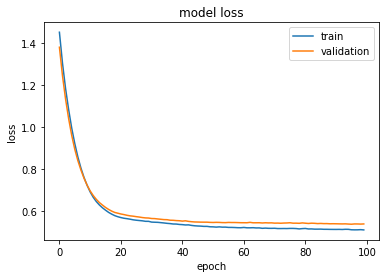

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

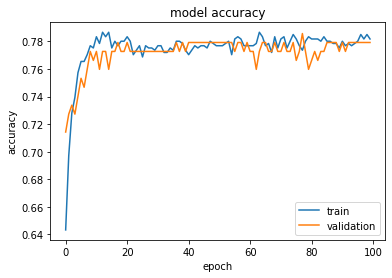

In [0]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

In [0]:
# Test predict
np.argmax(model.predict(X_val_scaled[1].reshape(1, model.inputs[0].shape[1])))

0

# Training Surrogate Model

In [0]:
import graphviz
from sklearn.tree import DecisionTreeClassifier, export_graphviz

In [0]:
X_s = X_train
y_s = np.argmax(model.predict(X_train_scaled), axis=1)
class_names_s = ['diabetes -ve', 'diabetes +ve']

In [0]:
tree_clf = DecisionTreeClassifier()
tree_clf = tree_clf.fit(X_s, y_s)

In [0]:
print("Surrogate Model Train Accuracy:", tree_clf.score(X_s, y_s))

Surrogate Model Train Accuracy: 1.0


In [0]:
export_graphviz(
    tree_clf,
    out_file="decision_tree.dot",
    feature_names=feature_names,
    class_names=class_names_s,
    node_ids=True,
    filled=True,
    rounded=True,
    special_characters=True
)

In [0]:
!dot -Tpng decision_tree.dot -o decision_tree.png

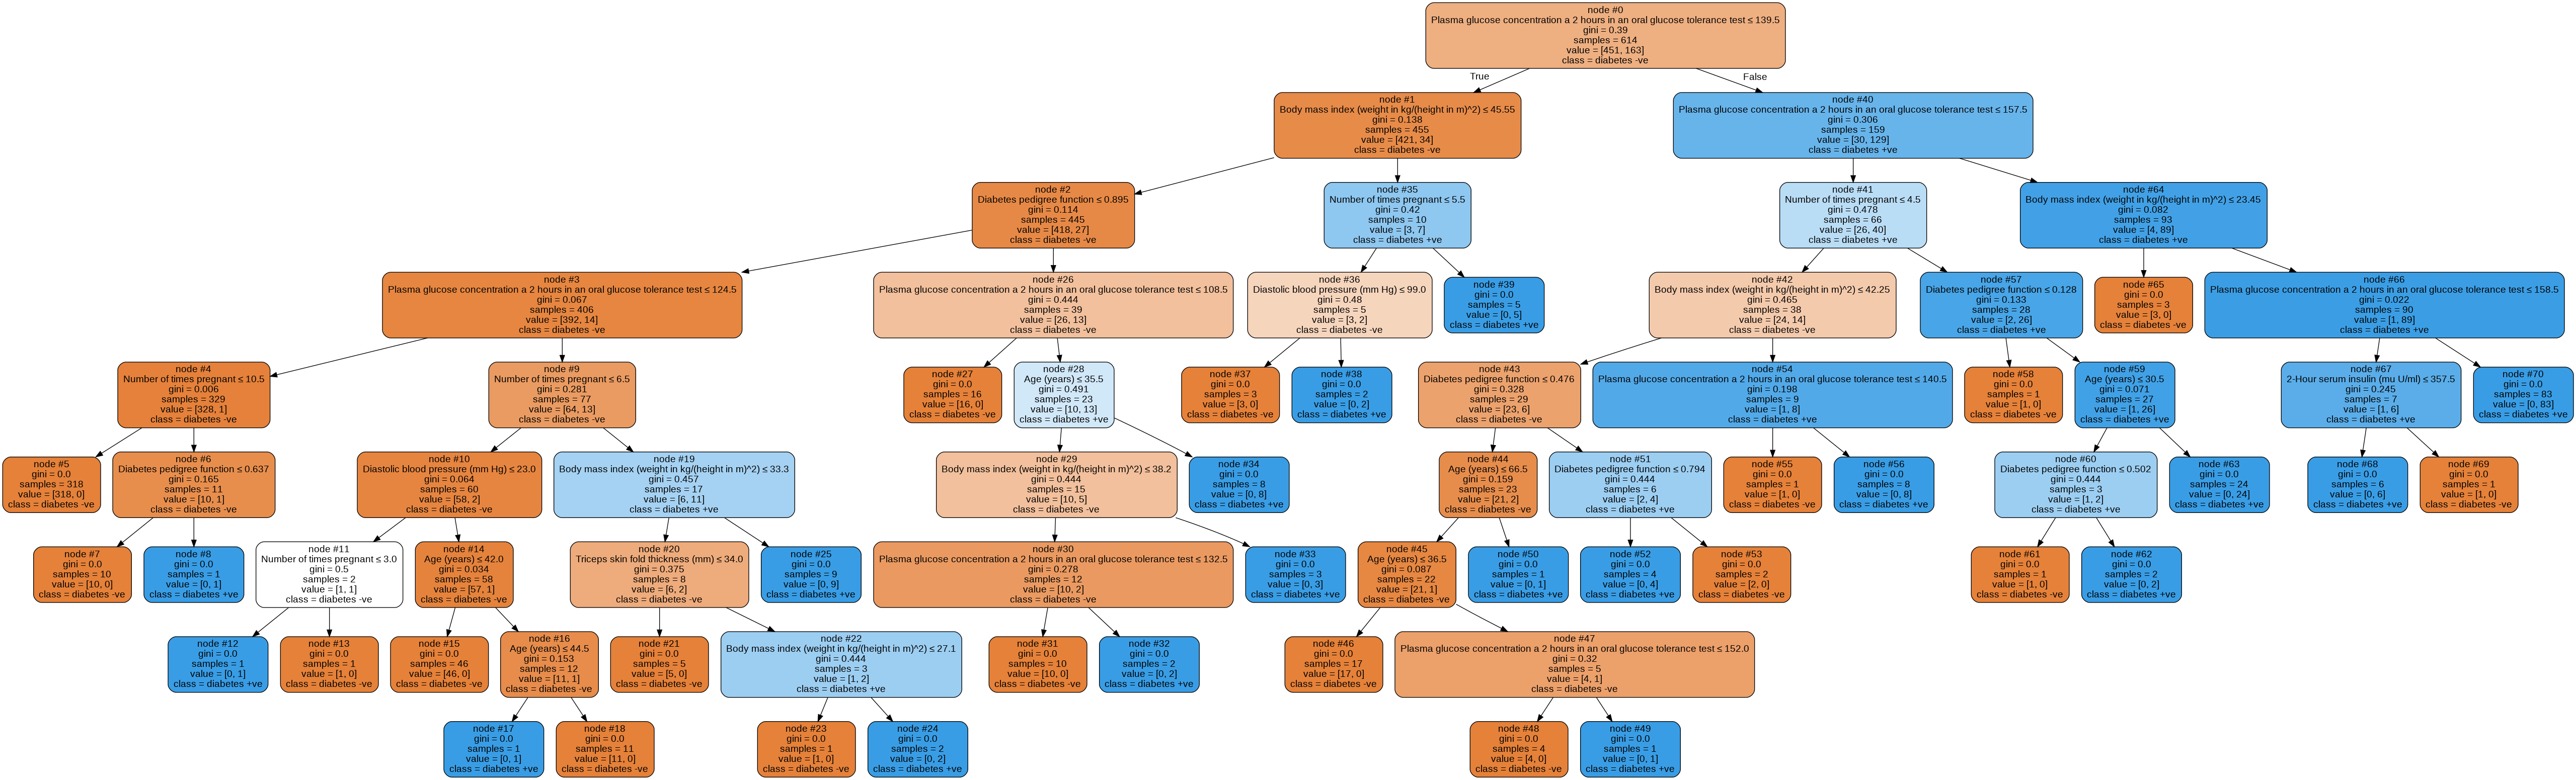

In [0]:
from IPython.display import Image
Image(retina=True, filename='decision_tree.png')

# Test Prediction with Explanation

In [0]:
selected_input = X_val[1].reshape(1, model.inputs[0].shape[1])
selected_input_scaled = X_val_scaled[1].reshape(1, model.inputs[0].shape[1])

In [0]:
# Show as pandas dataframe
selected_input_df = pd.DataFrame(columns=feature_names, data=selected_input)
selected_input_df

,Number of times pregnant,Plasma glucose concentration a 2 hours in an oral glucose tolerance test,Diastolic blood pressure (mm Hg),Triceps skin fold thickness (mm),2-Hour serum insulin (mu U/ml),Body mass index (weight in kg/(height in m)^2),Diabetes pedigree function,Age (years)
0,1.0,85.0,66.0,29.0,0.0,26.6,0.351,31.0


In [0]:
# Black-box model (Deep Learning) prediction
np.argmax(model.predict(selected_input_scaled))

0

In [0]:
# Surrogate model (Decision Tree) prediction
tree_clf.predict(selected_input)

array([0])

In [0]:
# Explain the prediction by Black-box model
decision_path = tree_clf.decision_path(selected_input)

In [0]:
level_length = len(decision_path.indices)
i = 1
for node_id in decision_path.indices:
  if i < level_length:
    # Ignore last level because it is the last node
    # without decision criteria or rule
    col_name = feature_names[tree_clf.tree_.feature[node_id]]
    threshold_value = tree_clf.tree_.threshold[node_id]
    rule = "{} <= {}".format(col_name, threshold_value)
    print("node#{}:".format(node_id), rule, selected_input_df[col_name].values)
  else:
    # Just print last node without rule
    print("node#{}".format(node_id))
  i = i + 1

node#0: Plasma glucose concentration a 2 hours in an oral glucose tolerance test <= 139.5 [85.]
node#1: Body mass index (weight in kg/(height in m)^2) <= 45.54999923706055 [26.6]
node#2: Diabetes pedigree function <= 0.8949999809265137 [0.351]
node#3: Plasma glucose concentration a 2 hours in an oral glucose tolerance test <= 124.5 [85.]
node#4: Number of times pregnant <= 10.5 [1.]
node#5
